# Parameter Identification Technique (PIT) on a linear Nomoto model

# Purpose
Show the general workflow by applying PIT regression on a very simple model

# Methodology
* Load time series from a ZigZag test
* Determine yaw rate and acceleration (compare with accelerometers from test).
* Find the best parameter values in the Nomoto model using OLS linear regression.

# Setup

In [1]:
# %load imports.py
%matplotlib inline
%load_ext autoreload
%autoreload 2

## External packages:
import pandas as pd
pd.options.display.max_rows = 999
pd.options.display.max_columns = 999
pd.set_option("display.max_columns", None)

import numpy as np
import os
import matplotlib.pyplot as plt

import plotly.express as px 
import plotly.graph_objects as go

import seaborn as sns
import sympy as sp
from sympy.physics.mechanics import (dynamicsymbols, ReferenceFrame,
                                      Particle, Point)
from sympy.physics.vector.printing import vpprint, vlatex
from IPython.display import display, Math, Latex
from src.substitute_dynamic_symbols import run, lambdify

import pyro

import sklearn
import pykalman
from statsmodels.sandbox.regression.predstd import wls_prediction_std
import statsmodels.api as sm

from scipy.integrate import solve_ivp

## Local packages:
from src.data import mdl




Duplicate key in file WindowsPath('C:/Users/maa/.matplotlib/stylelib/paper.mplstyle'), line 462 ('figure.figsize   : 5, 3   ## figure size in inches')
Duplicate key in file WindowsPath('C:/Users/maa/.matplotlib/stylelib/paper.mplstyle'), line 463 ('figure.dpi       : 100        ## figure dots per inch')


## Load test

In [2]:
df_runs = mdl.runs()

In [3]:
id=22775
df, units, meta_data = mdl.load(id=id)

In [4]:
meta_data.dropna()

A0                                                               0.722775
KXX                                                              0.331311
KZZ                                                              1.253641
TA                                                               0.206311
TF                                                               0.206311
Volume                                                           0.441027
beam                                                             0.946602
comment                                                       Circle 35SB
date                                                           2020-10-09
facility                                                              MDL
file_path_hdf5          \\sspa.local\lab\MeasuredataMDL\40199079\005\0...
gm                                                               0.136092
kg                                                               0.438908
lcg                                   

In [5]:
df.head()

Arr/Ind/Arr  Arr/Ind/Fri  Fan/Aft/Angle  \
time                                                              
0 days 00:00:26.669996          0.0          1.0       0.363455   
0 days 00:00:26.679998          0.0          1.0       0.363359   
0 days 00:00:26.690006          0.0          1.0       0.363420   
0 days 00:00:26.699996          0.0          1.0       0.363311   
0 days 00:00:26.710002          0.0          1.0       0.363380   

                        Fan/Aft/AngleOrder  Fan/Aft/CalcAngle  Fan/Aft/Fx  \
time                                                                        
0 days 00:00:26.669996            0.363314           0.363314    6.350474   
0 days 00:00:26.679998            0.363298           0.363298    6.619624   
0 days 00:00:26.690006            0.363283           0.363283    6.626957   
0 days 00:00:26.699996            0.363267           0.363267    6.354853   
0 days 00:00:26.710002            0.363252           0.363252    5.976993   

                        Fan/Aft/FxOrder  Fan/Aft/Rpm  Fan/Aft/RpmOrder  \
time                                                                     
0 days 00:00:26.669996         9.997757    39.535089         41.287582   
0 days 00:00:26.679998         9.997551    39.207038         41.287159   
0 days 00:00:26.690006         9.997345    40.499945         41.286739   
0 days 00:00:26.699996         9.997144    39.091256         41.286329   
0 days 00:00:26.710002         9.996948    38.878988         41.285927   

                        Fan/ForceFactor  Fan/Fore/Angle  Fan/Fore/AngleOrder  \
time                                                                           
0 days 00:00:26.669996             0.62        0.681240             0.680888   
0 days 00:00:26.679998             0.62        0.680858             0.680857   
0 days 00:00:26.690006             0.62        0.681226             0.680827   
0 days 00:00:26.699996             0.62        0.680885             0.680797   
0 days 00:00:26.710002             0.62        0.681035             0.680768   

                        Fan/Fore/CalcAngle  Fan/Fore/Fx  Fan/Fore/FxOrder  \
time                                                                        
0 days 00:00:26.669996            0.680888     5.975769          9.997757   
0 days 00:00:26.679998            0.680857     6.150300          9.997551   
0 days 00:00:26.690006            0.680827     6.242503          9.997345   
0 days 00:00:26.699996            0.680797     6.274332          9.997144   
0 days 00:00:26.710002            0.680768     6.179950          9.996948   

                        Fan/Fore/Rpm  Fan/Fore/RpmOrder  Hull/Acc/X1  \
time                                                                   
0 days 00:00:26.669996     34.449519          42.060705     0.305876   
0 days 00:00:26.679998     26.209653          42.060281    -0.085527   
0 days 00:00:26.690006     29.335785          42.059862     0.053753   
0 days 00:00:26.699996     41.570152          42.059451     0.371647   
0 days 00:00:26.710002     26.035979          42.059049    -0.101002   

                        Hull/Acc/Y1  Hull/Acc/Y2  Hull/Acc/Z1  Hull/Acc/Z2  \
time                                                                         
0 days 00:00:26.669996     0.200020    -0.192392     0.003395     0.214486   
0 days 00:00:26.679998    -0.159691    -0.234983     0.205034     0.663210   
0 days 00:00:26.690006    -0.121012     0.143173    -0.066824     0.115844   
0 days 00:00:26.699996     0.257393     0.326443    -0.603454    -0.441839   
0 days 00:00:26.710002    -0.477500     0.048957     0.215986    -0.194267   

                        Hull/Acc/Z3  Prop/PS/Rpm  Prop/PS/Thrust  \
time                                                               
0 days 00:00:26.669996     0.123971     5.525132       -0.059149   
0 days 00:00:26.679998    -0.421227     5.520644       -0.074466   
0 days 00:00:26.690006    -0.607471     5.482439       -0.088359   
0 

In [6]:
units = mdl.load_units()

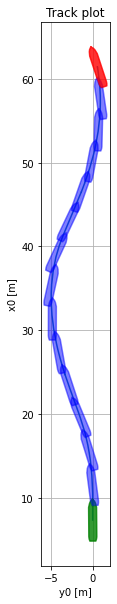

In [7]:
from mdldb.inspect import track_plot
fig,ax=plt.subplots()
fig.set_size_inches(10,10)
track_plot(df=df, lpp=meta_data.lpp, x_dataset='x0', y_dataset='y0',  psi_dataset='psi', beam=meta_data.beam, ax=ax);

## Yaw rate

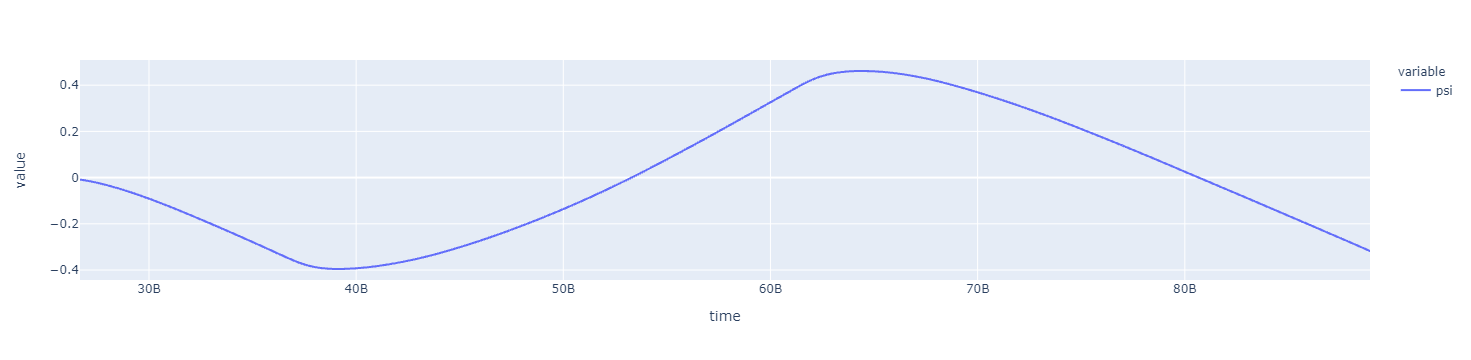

In [8]:
px.line(data_frame=df, y=['psi'], width=1400, height=300,)

In [9]:
t = df.index.total_seconds()
df['r_numerical'] = np.gradient(df['psi'],t)
df['r1d_numerical'] = np.gradient(df['r_numerical'],t)


## Yaw rate from Kalman filter

In [10]:
from pykalman import KalmanFilter

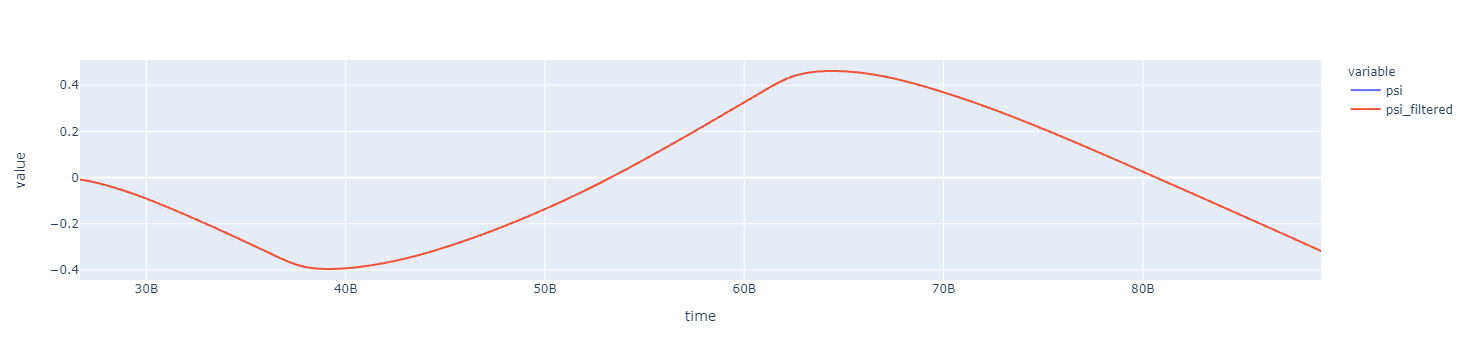

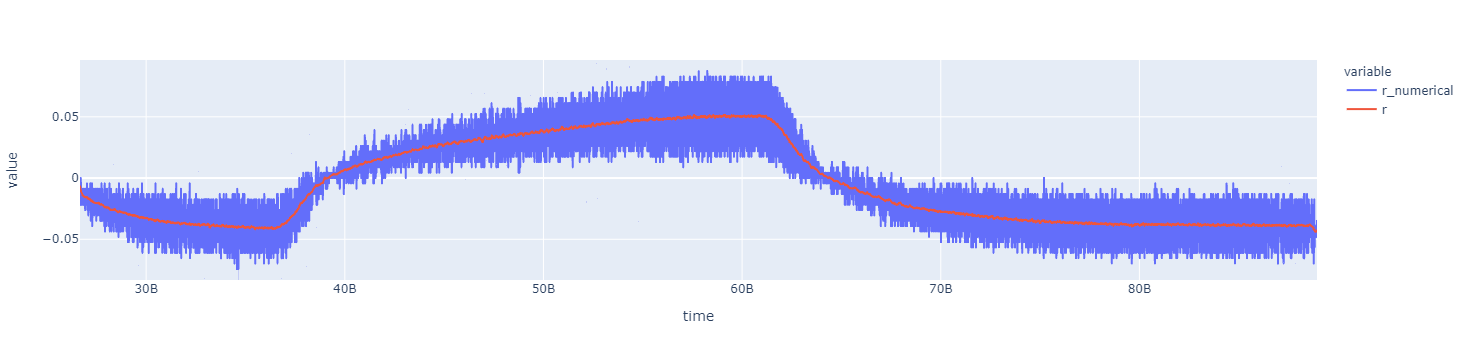

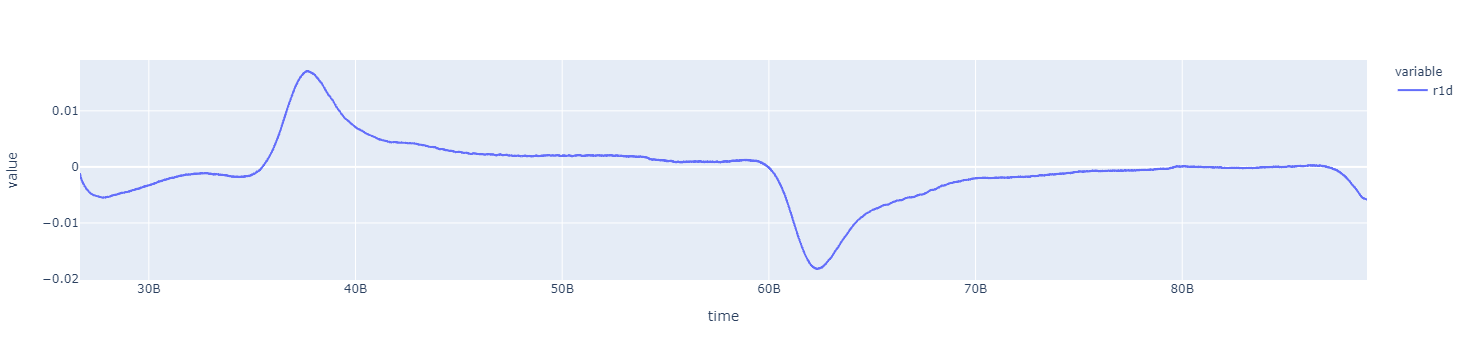

In [11]:
dt = t[1] - t[0]

A = np.array([[1, dt, 0.5*(dt**2)],
              [0, 1,            dt],
              [0, 0,            1]])

A = np.array([[1, dt, 0.5*(dt**2), 1/6*(dt**3)],
              [0,  1, dt         , 0.5*(dt**2)],
              [0,  0, 1          , dt],
              [0,  0, 0          , 1]])

kf = KalmanFilter(transition_matrices=A,
                  initial_state_mean = [df['psi'].mean(),0,0,0],
                  random_state=np.random.RandomState(0),
                  #transition_covariance=100 * np.eye(3),
                  #observation_covariance=100000 * np.eye(1),
                  #em_vars=[
                  #    'transition_covariance', 
                  #    #'observation_covariance', 
                  #    'initial_state_mean', 
                  #    'initial_state_covariance'
                  #    ],
                  )

observations = df['psi']
states_pred = kf.em(observations).smooth(observations)[0]
#states_pred = kf.filter(observations)[0]


df['psi_filtered'] = states_pred[:,0]
df['r'] = states_pred[:,1]
df['r1d'] = states_pred[:,2]

display(px.line(data_frame=df, y=['psi','psi_filtered'], width=1400, height=300,))
display(px.line(data_frame=df, y=['r_numerical','r'], width=1400, height=300,))
display(px.line(data_frame=df, y=['r1d'], width=1400, height=300,))

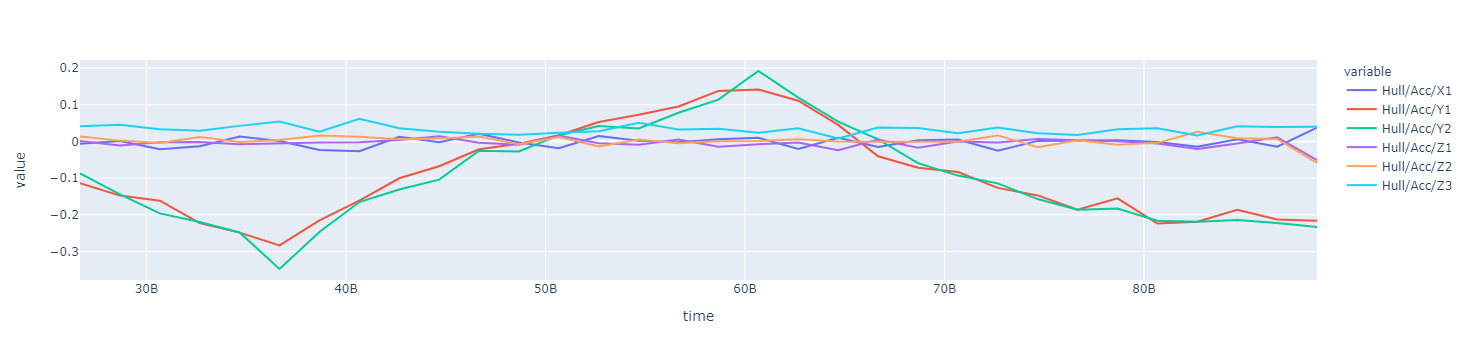

In [12]:
display(px.line(data_frame=df.resample('2S').mean(), y=['Hull/Acc/X1','Hull/Acc/Y1','Hull/Acc/Y2','Hull/Acc/Z1','Hull/Acc/Z2','Hull/Acc/Z3'], width=1400, height=300,))

# First order Nomoto model for ship maneuvering dynamics
The first order Nomoto model can be written as:

In [13]:
K, delta, T_1, T_2 = sp.symbols('K delta T_1 T_2')
r = dynamicsymbols('r')

eq_nomoto = sp.Eq(-K*delta,
                 r + T_1*r.diff() + T_2*r.diff().diff())
Math(vlatex(eq_nomoto))

<IPython.core.display.Math object>

where $r$ is yaw rate with its time derivatives and $\delta$ is the rudder angle. $K$, $T_{1}$
 and $T_{1}$ are the coefficients describing the hydrodynamics of the ship.
 
For slow manoeuvres this equation can be further simplified by removing the $\ddot{r}$ term:

In [14]:
eq_nomoto_simple = eq_nomoto.subs(r.diff().diff(),0)
Math(vlatex(eq_nomoto_simple))

<IPython.core.display.Math object>

In [15]:
eq_r1 = sp.Eq(r.diff(),
             sp.solve(eq_nomoto_simple, r.diff())[0])
r1d_lambda = lambdify(sp.solve(eq_nomoto_simple, r.diff())[0])
Math(vlatex(eq_r1))


<IPython.core.display.Math object>

In [16]:
def nomoto(t,states,df_control,params):
    """
    Simulation model for heading and yaw rate using Nomoto with only K and T_1
    """
    # states:
    psi = states[0]
    r = states[1]
    
    index = df_control.index.get_loc(t, method='nearest')
    delta = float(df_control['delta'].iloc[index])
    r1d_ = r1d_lambda(K=params['K'], T_1=params['T_1'], delta=delta, r=r)
    d_states_dt = np.array([r,r1d_])
    return d_states_dt

## Simulate a pull out manoeuvre
Simulating a simple pull out manoeuvre:

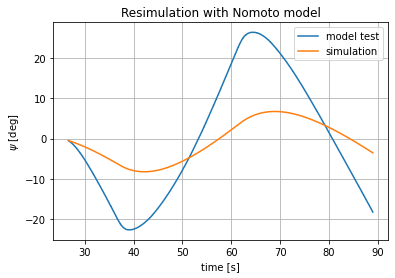

In [17]:
params = {
    'K' :  0.1,
    'T_1' : 10,
}

states_0 = np.array([df.iloc[0]['psi'],df.iloc[0]['r']])

df_control = df.copy()
df_control.index = df_control.index.total_seconds()
t = df_control.index

sol = solve_ivp(fun = nomoto,t_span=[t[0],t[-1]],t_eval=t, y0 = states_0, args=(df_control,params))
psi = sol.y[0,:]
r = sol.y[1,:]

fig,ax=plt.subplots()
df_control['psi_deg'] = np.rad2deg(df_control['psi'])
df_control.plot(y='psi_deg', label='model test', ax=ax)
ax.plot(t,np.rad2deg(psi), label='simulation');
ax.grid(True)
ax.set_title('Resimulation with Nomoto model')
ax.set_ylabel('$\psi$ [deg]')
ax.set_xlabel('time [s]');
ax.legend()


## Regress nomoto parameters

In [18]:
eq_r1

Eq(Derivative(r(t), t), -(K*delta + r(t))/T_1)

In [19]:
import sympy.physics.mechanics as me

me.find_dynamicsymbols(eq_r1)

{Derivative(r(t), t), r(t)}

In [20]:
eq_r1.rhs

-(K*delta + r(t))/T_1

In [21]:
y = df_control['r1d']
X = df_control[['delta','r']] 

model = sm.OLS(y,X)
results = model.fit()
results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 OLS Regression Results                                
=======================================================================================
Dep. Variable:                    r1d   R-squared (uncentered):                   0.869
Model:                            OLS   Adj. R-squared (uncentered):              0.869
Method:                 Least Squares   F-statistic:                          2.059e+04
Date:                Thu, 27 May 2021   Prob (F-statistic):                        0.00
Time:                        18:22:22   Log-Likelihood:                          30089.
No. Observations:                6228   AIC:                                 -6.017e+04
Df Residuals:                    6226   BIC:                                 -6.016e+04
Df Model:                           2                                                  
Covariance Type:            nonrobust                                                  
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
delta         -0.0602      0.000   -202.556      0.000      -0.061      -0.060
r             -0.2475      0.001   -170.759      0.000      -0.250      -0.245
==============================================================================
Omnibus:                      472.259   Durbin-Watson:                   0.002
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             2571.349
Skew:                           0.092   Prob(JB):                         0.00
Kurtosis:                       6.142   Cond. No.                         10.3
==============================================================================

Notes:
[1] R² is computed without centering (uncentered) since the model does not contain a constant.
[2] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

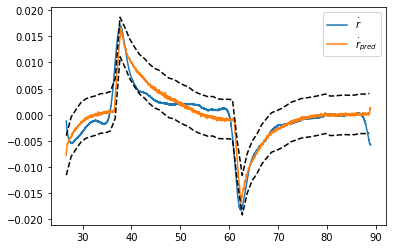

In [22]:
r1d_pred = results.predict(X)
X_ = X.iloc[::100, :]
prstd, iv_l, iv_u = wls_prediction_std(results, exog=X_, alpha=0.05)

fig,ax=plt.subplots()
ax.plot(t,y, label=r'$\dot{r}$')
ax.plot(t,r1d_pred, label=r'$\dot{r}_{pred}$')

ax.plot(X_.index,iv_l, 'k--')
ax.plot(X_.index,iv_u, 'k--')
ax.legend()

In [23]:
params['T_1'] = -1/results.params['r']
params['K'] = -results.params['delta']*params['T_1']

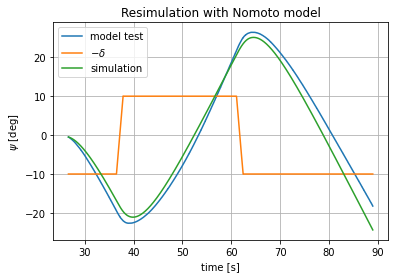

In [24]:
states_0 = np.array([df.iloc[0]['psi'],df.iloc[0]['r']])

df_control = df.copy()
df_control['delta']+=np.deg2rad(1)  # Cheating?

df_control.index = df_control.index.total_seconds()
t = df_control.index

sol = solve_ivp(fun = nomoto,t_span=[t[0],t[-1]],t_eval=t, y0 = states_0, args=(df_control,params))
psi = sol.y[0,:]
r = sol.y[1,:]

fig,ax=plt.subplots()
df_control['psi_deg'] = np.rad2deg(df_control['psi'])
df_control.plot(y='psi_deg', label='model test', ax=ax)

df_control['-delta_deg'] = -np.rad2deg(df_control['delta'])
df_control.plot(y='-delta_deg', label=r'$-\delta$', ax=ax)

ax.plot(t,np.rad2deg(psi), label='simulation');
ax.grid(True)
ax.set_title('Resimulation with Nomoto model')
ax.set_ylabel('$\psi$ [deg]')
ax.set_xlabel('time [s]');
ax.legend()
